<a href="https://colab.research.google.com/github/felixn95/oil-palm-detection/blob/main/model_training/densenet_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Densenet** - Training & Tracking Models using NeptuneAI

#### In this notebook, the training is applied on the pretrained model **densenet** (https://pytorch.org/hub/pytorch_vision_densenet/) using the FastAI learner.

During the training, different versions of the model combined with different approachs are applied. For later comparison with different models, all runs are tracked with their metrics in a centralized project in neptuneAI, where all teammembers collaborate togehter.

In [1]:
!pip install torch torchvision --q

In [2]:
!pip install timm wwf fastai neptune neptune-fastai --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.5/481.5 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.0 MB/s eta 0:00:00


Since we found no convienent way to host the already preprocessed dataset for easy reuse in colab runs, we just repeat the preprocessing steps here in one cell again. Informations therefore can be found in the preprocessing notebook in github.

In [3]:
import os
import pandas as pd

# load data set & unzip
os.environ['KAGGLE_USERNAME'] = 'felixn95'
os.environ['KAGGLE_KEY'] = 'f5ebbbcff77a95e44ac5acb1093c4c6a'

!kaggle competitions download -c widsdatathon2019
!unzip -q widsdatathon2019.zip
!unzip -q train_images.zip
!unzip -q leaderboard_test_data.zip

# Define Paths
train_images = '/content/train_images'
test_images =  '/content/leaderboard_test_data'
train_labels = '/content/traininglabels.csv'
test_labels = '/content/testlabels.csv'

def adjust_image_ids(input_csv_path, output_csv_path):
    """
    Adjusts the image_ids in the input CSV file by removing the year digits before '.jpg'
    and saves the modified DataFrame to the output CSV path.
    """

    df = pd.read_csv(input_csv_path)

    # Modify the 'image_id' column
    df['image_id'] = df['image_id'].str.replace(r'\d{4}\.jpg', '.jpg', regex=True)

    # Save to the output CSV file
    df.to_csv(output_csv_path, index=False)


adjust_image_ids(train_labels, 'traininglabels_processed.csv')
adjust_image_ids(test_labels, 'testlabels_processed.csv')

train_labels = '/content/traininglabels_processed.csv'
test_labels = '/content/testlabels_processed.csv'

def filter_missing_images(csv_file, image_dir, target_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Filter out rows where the image file does not exist
    df_filtered = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))]

    # Save the filtered DataFrame
    df_filtered.to_csv(target_file, index=False)

filter_missing_images(train_labels, train_images, '/content/train_labels_filtered.csv')
filter_missing_images(test_labels, test_images, '/content/test_labels_filtered.csv')

train_labels = '/content/train_labels_filtered.csv'
test_labels = '/content/test_labels_filtered.csv'

 96% 443M/460M [00:03<00:00, 148MB/s]
100% 460M/460M [00:03<00:00, 133MB/s]


# Training & Tracking

In [4]:
import os
import neptune
import torch
import wwf
import fastai
import timm
from wwf.vision.timm import timm_learner
from fastai.callback.all import SaveModelCallback
from fastai.vision.all import *
from neptune.integrations.fastai import NeptuneCallback
from neptune.types import File

def get_x(row, train_images):
    return os.path.join(train_images, row['image_id'])

def get_y(row):
    return row['has_oilpalm']

def create_dataloader(item_size, batch_size=64):
    # Create data block
    palm_data_block = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=partial(get_x, train_images=train_images),
        get_y=get_y,
        splitter=RandomSplitter(valid_pct=0.2, seed=42),
        item_tfms=Resize(item_size),
        batch_tfms=aug_transforms()
    )

    # Create data loaders
    dls = palm_data_block.dataloaders(pd.read_csv(train_labels), bs=batch_size)
    return dls


## Created Methods for easier Training and Tracking

In [5]:
def train_model_with_optimal_lr(model, epochs, item_size, project_name, tag, batch_size):
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI2ZjExOTA0Yy0zZjhhLTQ3Y2MtYjYzNy1kY2Q1OGMwODAyYWUifQ=="
    run = neptune.init_run(project=project_name, api_token=api_token, tags=tag)

    dls = create_dataloader(item_size, batch_size)
    learner = vision_learner(dls, arch=model, metrics=accuracy)

    # Find optimal learning rate
    lr_min, lr_steep = learner.lr_find(suggest_funcs=(valley, steep))

    # Neptune callback
    neptune_cbk = NeptuneCallback(run=run)

    # Callback for logging metrics after each epoch
    class NeptuneRecorderCallback(Callback):
      def after_epoch(self):
          # Get the current epoch number
          epoch = self.learn.epoch

          # Convert the AvgMetric to a float and log the accuracy
          # Save the metrics in different paths, to make sure each epoch is saved
          accuracy = self.learn.recorder.metrics[-1].value
          run[f'epoch_{epoch}/accuracy'].log(accuracy)

          # Log the validation loss
          valid_loss = self.learn.recorder.log[-1]
          run[f'epoch_{epoch}/valid_loss'].log(valid_loss)


    # Train with callbacks
    learner.fit_one_cycle(epochs, lr_max=lr_min,
                          cbs=[SaveModelCallback(),
                               EarlyStoppingCallback(monitor='valid_loss', min_delta=0.02, patience=3),
                               neptune_cbk,
                               NeptuneRecorderCallback()])

    run.stop()
    learner.remove_cb(neptune_cbk)
    learner.export(f"./{tag}")

    # Free resources
    del learner
    torch.cuda.empty_cache()


def train_multiple_models_with_optimal_lr(models, epochs_list, item_size, project_name, batch_size):
    for model in models:
        for epochs in epochs_list:
            # Constructs a unique tag for each training run (i.e resnet18_3_epochs)
            tag = f'{model}_{epochs}_epochs'

            # Call the training function with the current model and epoch count
            train_model_with_optimal_lr(model, epochs, item_size, project_name, tag, batch_size)

The EarlyStoppingCallback in the context of training machine learning models, specifically here with FastAI, is a feature that monitors the training process and stops it early if certain conditions are met. Let's break down the parameters:

monitor='valid_loss': This specifies the metric to be monitored. In this case, it's the validation loss. The callback will keep an eye on this metric to decide when to stop the training.

min_delta=0.01: This sets the minimum change in the monitored metric to qualify as an improvement. Here, it means that the validation loss must decrease by at least 0.01 to be considered an improvement.

patience=3: This is the number of epochs with no improvement after which training will be stopped. In this case, if the validation loss does not decrease by at least 0.01 for 3 consecutive epochs, the training process will be halted.

So, putting it all together: The EarlyStoppingCallback is set to monitor the validation loss during training. If the validation loss does not improve by at least 0.01 for 3 consecutive epochs, the training process will be stopped early. This helps in preventing overfitting and can also save time and computational

In [6]:
# Available pretrained models from fast.ai
model_set = {
    "resnet18", "resnet34", "resnet50", "resnet101", "resnet152",
    "squeezenet1_0", "squeezenet1_1",
    "densenet121", "densenet169", "densenet201", "densenet161",
    "vgg16_bn", "vgg19_bn",
    "alexnet"
}

# Densenet169 and Densenet121

The models were trained with a batch size of 64, 3 and 5 epochs each.

<ipython-input-5-b8ce841360f5>:3: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(project=project_name, api_token=api_token, tags=tag)


https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-18


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/57.4M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.354863,0.342715,0.930920,02:50
1,0.225673,0.282136,0.932913,02:49
2,0.197408,0.311703,0.930588,02:49


Better model found at epoch 0 with valid_loss value: 0.34271517395973206.
Better model found at epoch 1 with valid_loss value: 0.2821355164051056.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 12 operations to synchronize with Neptune. Do not kill this process.
All 12 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-18/metadata
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-19


epoch,train_loss,valid_loss,accuracy,time
0,0.363981,0.373622,0.930588,02:50
1,0.282500,0.225962,0.921289,02:48
2,0.225206,0.204067,0.932248,02:48
3,0.195647,0.195641,0.929259,02:48
4,0.209239,0.198027,0.933245,02:48


Better model found at epoch 0 with valid_loss value: 0.37362179160118103.
Better model found at epoch 1 with valid_loss value: 0.22596189379692078.
Better model found at epoch 2 with valid_loss value: 0.20406724512577057.
Better model found at epoch 3 with valid_loss value: 0.19564108550548553.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 10 operations to synchronize with Neptune. Do not kill this process.
All 10 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-19/metadata
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-20


model.safetensors:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.360076,0.239638,0.925606,02:20
1,0.225779,0.221241,0.931916,02:19
2,0.197624,0.202532,0.932913,02:19


Better model found at epoch 0 with valid_loss value: 0.23963762819766998.
Better model found at epoch 1 with valid_loss value: 0.22124090790748596.
Better model found at epoch 2 with valid_loss value: 0.20253196358680725.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 32 operations to synchronize with Neptune. Do not kill this process.
All 32 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-20/metadata
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-21


epoch,train_loss,valid_loss,accuracy,time
0,0.413982,0.251001,0.932581,02:20
1,0.238994,0.231034,0.924610,02:21
2,0.226769,0.209808,0.933577,02:19
3,0.196584,0.204905,0.928927,02:19
4,0.187261,0.200852,0.929924,02:19


Better model found at epoch 0 with valid_loss value: 0.2510005235671997.
Better model found at epoch 1 with valid_loss value: 0.2310343086719513.
Better model found at epoch 2 with valid_loss value: 0.20980775356292725.
Better model found at epoch 3 with valid_loss value: 0.20490527153015137.
Better model found at epoch 4 with valid_loss value: 0.20085228979587555.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 34 operations to synchronize with Neptune. Do not kill this process.
All 34 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-21/metadata


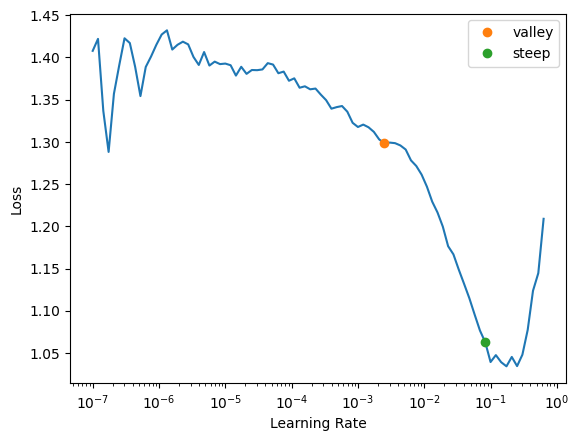

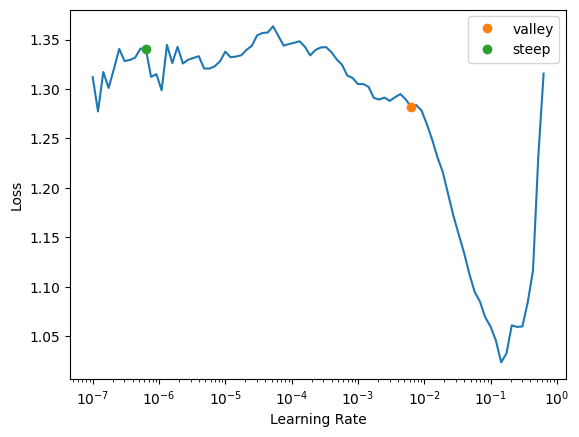

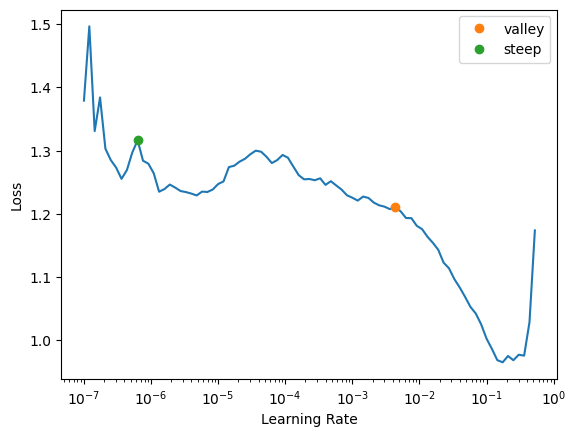

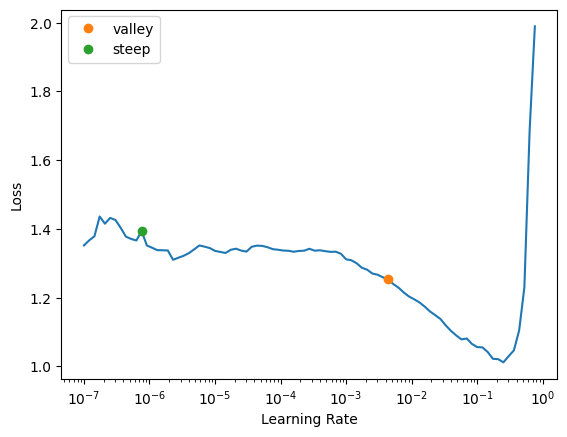

In [7]:
item_size = 256

# try different versions of densenet models

models = ["densenet169", "densenet121"]  # models to train
epochs_list = [3,5]  # epochs to test per models
project_name = 'model-comparison'
batch_size = 64

train_multiple_models_with_optimal_lr(models, epochs_list, item_size, project_name, batch_size)

# Evaluation

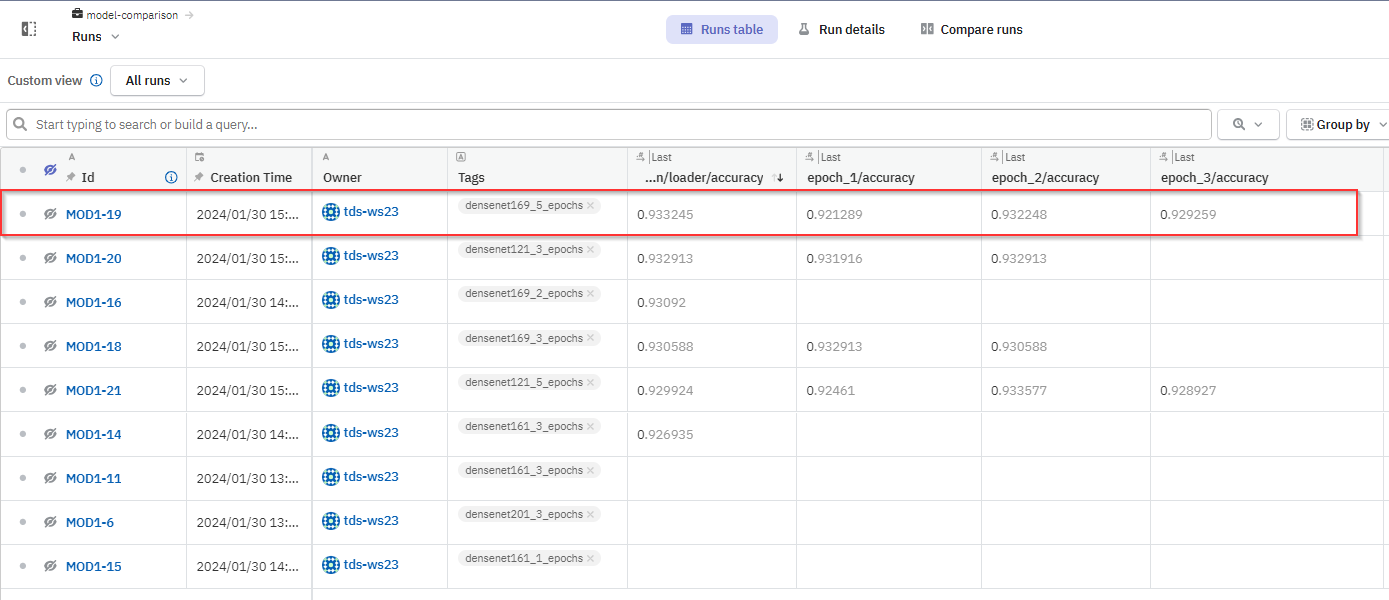

As can be seen in the overview, the best performance was done by

- densenet169 after 5 epochs
- accuracy: 0.933245

# Densenet201

Due to the higher size of this models, it was trained in a single run with 3 epochs and a batch size of 32 (64 was running into out of memory).

<ipython-input-6-d01cf3b6a9b7>:3: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(project=project_name, api_token=api_token, tags=tag)


https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-8


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/81.1M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.384864,0.244507,0.933245,03:43
1,0.288386,0.266210,0.913650,03:46
2,0.216117,0.303740,0.931584,03:41


Better model found at epoch 0 with valid_loss value: 0.24450699985027313.
No improvement since epoch 0: early stopping
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 44 operations to synchronize with Neptune. Do not kill this process.
All 44 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/tds-ws23/model-comparison/e/MOD1-8/metadata


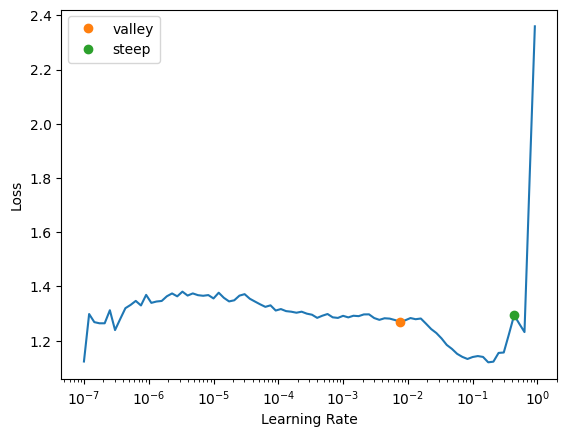

In [8]:
item_size = 256

# try different versions of densenet models

models = ["densenet201"]  # models to train
epochs_list = [3]  # epochs to test per models
project_name = 'model-comparison'
batch_size = 32

train_multiple_models_with_optimal_lr(models, epochs_list, item_size, project_name, batch_size)


### Some explanations for the result metrics:
**train_loss**: This is the loss calculated on the training dataset during training. It's a measure of the error between the model's predictions and the actual values. A lower train_loss indicates the model is performing better on the training data.

**valid_loss**: This is the loss calculated on a separate validation dataset that is not used for training. It's used to evaluate how well the model is generalizing to new, unseen data. Like train_loss, a lower valid_loss is better.

**accuracy**: This measures the percentage of correct predictions made by the model. Higher accuracy indicates better performance.

Regarding the observation that the model's performance (as indicated by valid_loss and accuracy) gets worse after the first epoch:

**Overfitting**: The model might be overfitting the training data. This means it's learning the training data too well, including its noise and outliers, which harms its performance on new data (the validation set).

**Learning Rate:** If the learning rate is too high, the model may overshoot the optimal point in the loss landscape.

Unfortunetaly, also runs with different learning rate did not improve the accuracy. Nevertheless, an accuracy of 0.933245 is not bad.  
